# ACCESS-OM2 1$^\circ$

This notebook documents our first attempt to run and analyse output from the ACCESS-OM2 Pre-release, implemented at 1°.


## Current Status


|** Run Name** | **Forcing** | ** Run ** | ** Status **|
|--------------|---------|-------------------------------------------------|-------------|
|1deg_jra55_ryf_spinup1 | JRA55 RYF9091| A short 10 year spinup with first pre-release code. Had bugs in runoff and salt fluxes.  <br> **IGNORE RUN: `rotate_winds=False`** | Aborted after 10 years.| 
|1deg_jra55_ryf_spinup2 | JRA55 RYF9091| Second attempt at 1° test. There are significant problems with salt and mass conservation in this run.| Stopped at 100 years.| 
|1deg_jra55_ryf_spinup3 | JRA55 RYF9091| Nic's initial 1° test. Still problems with salinity. Also, much of this run has problems with the ocean.nc files. | Stopped at 80 years.| 
|1deg_jra55_ryf_spinup4 | JRA55 RYF9091| Nic's improved 1° test. This simulation seems to have fixed the salt and volume imbalance, but is missing some diagnostics.| Up to 25 years.| 
|1deg_jra55_ryf_spinup5 | JRA55 RYF9091| Andy's 1° test. Unfortunately, this run reverted to the old ice_salt_concentration = 0.004 namelist setting, so melt and salt are unbalanced. | Stopped at year 40.| 
|1deg_jra55_ryf_spinup6 | JRA55 RYF9091| Andy's New & Improved 1° test. Again, this has a salt imbalance | Stopped after 24 years.| 
|1deg_jra55_ryf_spinup7 | JRA55 RYF9091| Same as spinup6, but with the Red Sea fix switched off. | Stopped after 28 years.| 
|1deg_jra55_ryf_spinup8 | JRA55 RYF9091| Same as spinup7, but update to Nic's new executable where we **think** the melt flux is now handled correctly. Turned Red Sea fix back on after year 4. This is running smoothly, but I can't get the timestep beyond 2160 (we are hoping for 3600).  | Stopped at year 184.| 
|1deg_jra55_ryf_spinup9 | JRA55 RYF9091| Same as spinup8 but with massless ice (max_ice_thickness=0.0). We hoped that this would improve model stability, but it didn't.  | 25 years in| 
|1deg_jra55_ryf8485_spinup1 | JRA55 RYF8485| Abhishek's first attempt at an RYF8485 spinup. Model was behaving itself but we started from the wrong initial condition, so stopped it. | Stopped after 30 years.| 
|1deg_jra55_ryf8485_spinup2 | JRA55 RYF8485| Abhishek's 2nd attempt at an RYF8485 spinup. Going well so far.| At 80 years.| 

### Notes
* Massless ice didn't fix our stability problems. We are still getting crashes in Bering Strait. Need to find our what is happening here.
* Fabio has suggested that we should increase teh SS restoring timescale to 60 days.
* Fabio has suggested we should use MDPPM over Sweby advection schemes.
* We should probably change the truncate_velocity to False.

**Last updated 17 September 2017**

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [4]:
cc.build_index()

Searching /g/data3/hh5/tmp/cosima/
Searching /g/data1/v45/APE-MOM
Found 64843 .nc files
Using database sqlite:////g/data1/v45/cosima-cookbook/cosima-cookbook.db
Files already indexed: 55534
Files found but not yet indexed: 9368
Indexing new .nc files...
[########################################] | 100% Completed | 25.9s
Found 100003 new variables
Saving results in database...
Indexing complete.


True

## Experiments

In [5]:
configuration = 'access-om2'
expts = cc.get_experiments(configuration)

configuration = 'mom-sis'
expts.extend(cc.get_experiments(configuration))
display(expts)

['1deg_jra55_ryf_spinup4',
 '1deg_jra55_ryf_spinup8',
 '1deg_jra55_ryf_spinup3',
 '1deg_jra55_ryf_spinup6',
 '1deg_jra55_ryf_spinup2',
 '1deg_jra55_ryf_spinup5',
 '1deg_jra55_ryf_spinup1',
 '1deg_jra55_ryf_spinup7',
 '1deg_jra55_ryf_spinup9',
 '1deg_jra55_ryf8485_spinup1',
 '1deg_jra55_ryf8485_spinup2',
 '1deg_jra55_ryf_RCP45',
 'mom-sis_jra-ryf',
 'mom-sis_core-nyf']

In [2]:
# This subset of cases are the important ones
esub = ['1deg_jra55_ryf_spinup8',
 '1deg_jra55_ryf8485_spinup2',
 '1deg_jra55_ryf_RCP45',
 #'mom-sis_jra-ryf',
 #'mom-sis_core-nyf'
       ]

## Wind Stress
Just a simple plot showing zonally averaged zonal wind stress from each case.

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


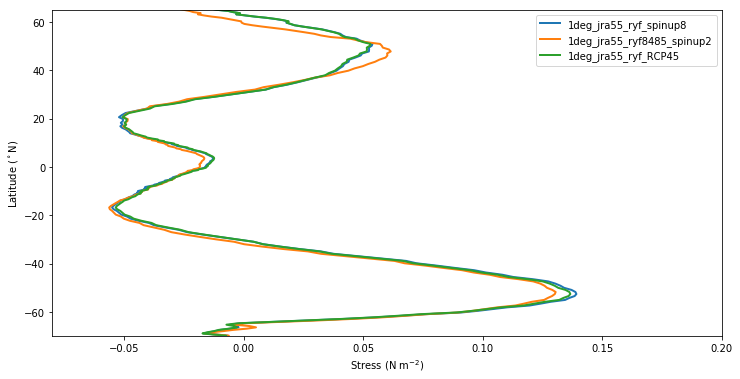

In [11]:
cc.plots.wind_stress(esub)

## Ocean Scalars
The following series of plots shows global timeseries of key metrics.

In [12]:
# If you want to clear stuff
# cc.diagnostics.annual_scalar.clear()

HBox(children=(IntProgress(value=0, description='variables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

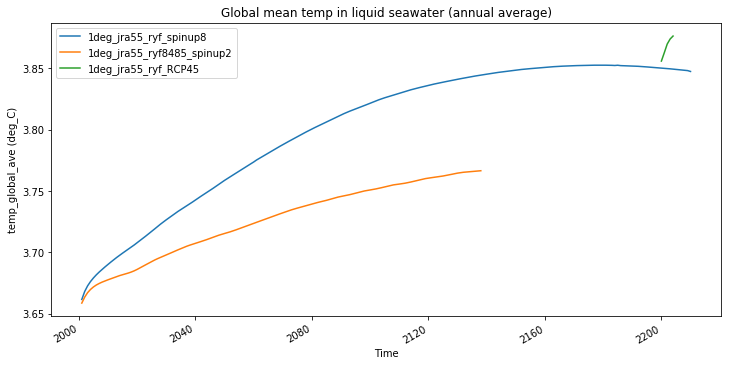

In [13]:
cc.plots.annual_scalar(esub, 'temp_global_ave')

HBox(children=(IntProgress(value=0, description='variables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

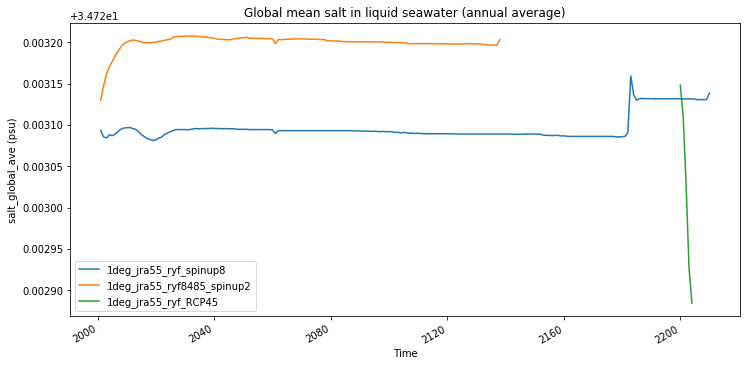

In [14]:
cc.plots.annual_scalar(esub, 'salt_global_ave')

HBox(children=(IntProgress(value=0, description='variables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

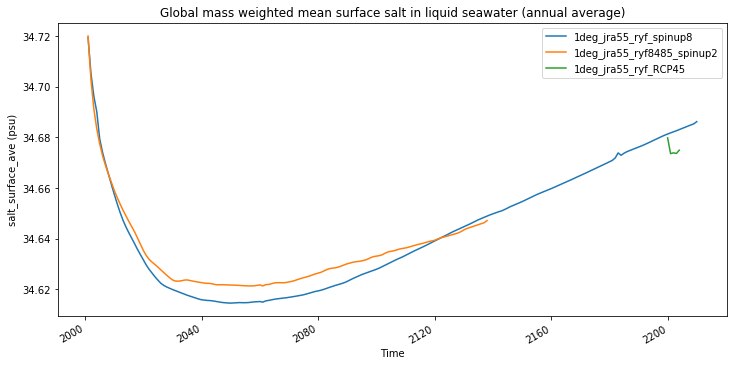

In [15]:
cc.plots.annual_scalar(esub, 'salt_surface_ave')

HBox(children=(IntProgress(value=0, description='variables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

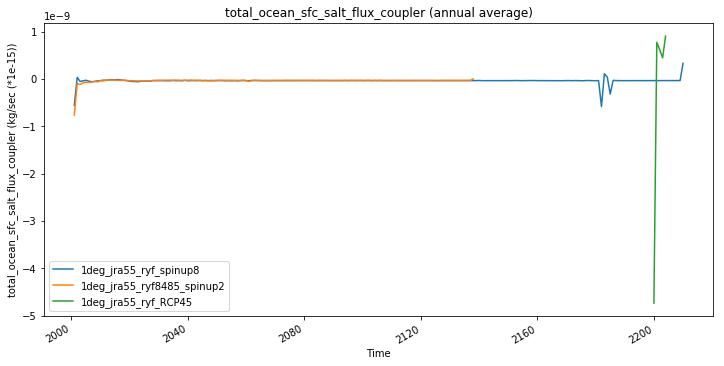

In [16]:
cc.plots.annual_scalar(esub, 'total_ocean_sfc_salt_flux_coupler')

HBox(children=(IntProgress(value=0, description='variables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

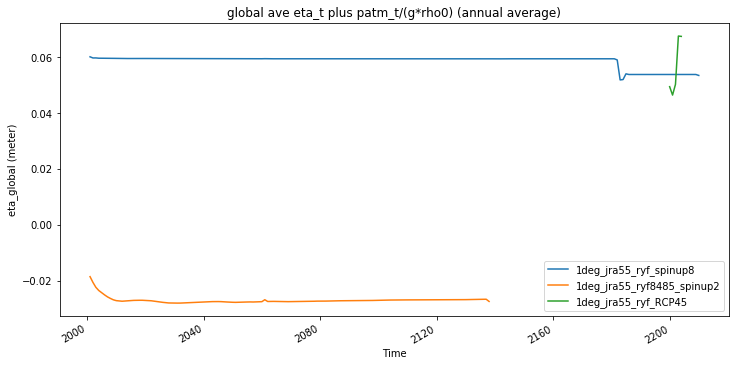

In [17]:
cc.plots.annual_scalar(esub, 'eta_global')

In [11]:
variables = cc.netcdf_index.get_scalar_variables(configuration)

In [12]:
from ipywidgets import widgets, interact, interactive, fixed
interactive(cc.plots.annual_scalar,
            expts=fixed(esub),
            variable=widgets.Dropdown(options=variables, description='Scalar Variable:'))

A Jupyter Widget

# Drake Passage Transport

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

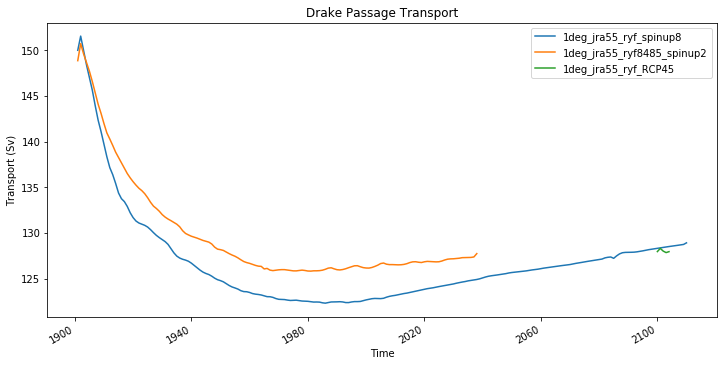

In [18]:
cc.plots.drake_passage(esub)

# Meridional Overturning Circulation

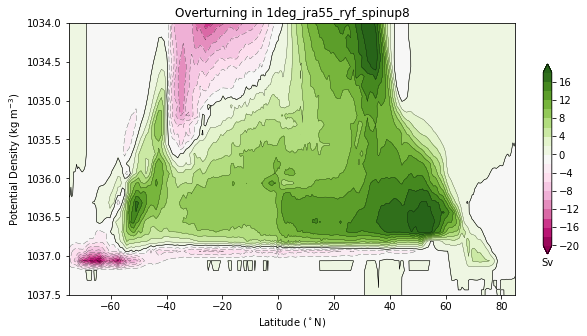

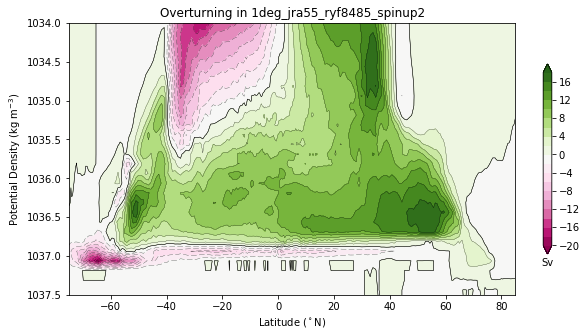

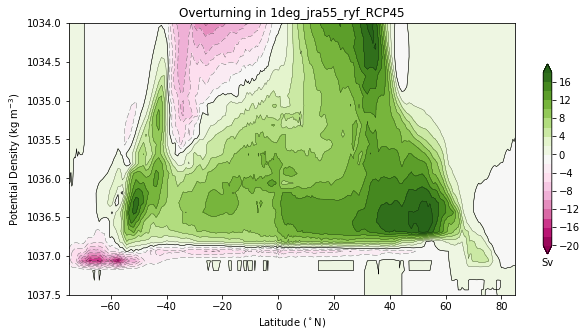

In [3]:
for e in esub: 
    cc.plots.psi_avg(e,3,GM=True)

In [19]:
expt = esub[0]
n=4
def op(p):
        summed_p = p.sum('grid_xt_ocean')
        summed_p.attrs['units'] = p.units
        return summed_p
psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          op=op,
                          chunks={'potrho': None}, n=n,
                          time_units = 'days since 1900-01-01')

In [21]:
psiGM

<xarray.DataArray 'ty_trans_rho' (time: 8, potrho: 80, grid_yu_ocean: 300)>
dask.array<concatenate, shape=(8, 80, 300), dtype=float64, chunksize=(1, 80, 100)>
Coordinates:
  * potrho         (potrho) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 ...
  * grid_yu_ocean  (grid_yu_ocean) float64 -77.75 -77.51 -77.26 -77.01 ...
  * time           (time) datetime64[ns] 2102-05-14T12:00:00 ...
Attributes:
    units:    kg/s

# Sea Surface Temperature
LH column shows SST, RH column shows difference from Year 1.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


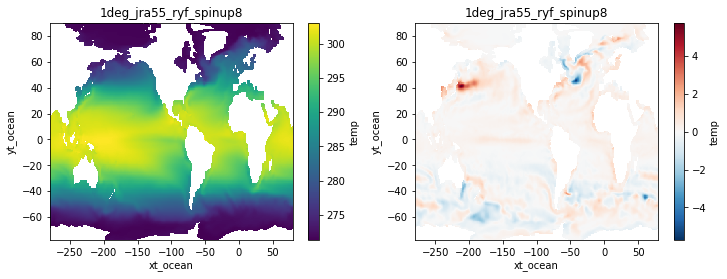

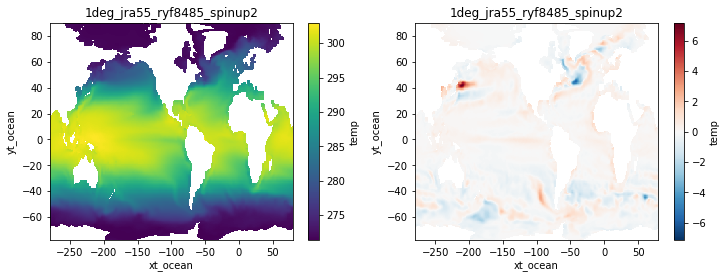

In [20]:
cc.plots.sea_surface_temperature(esub[:2])

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


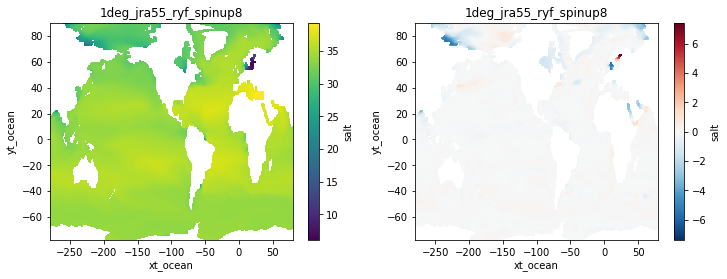

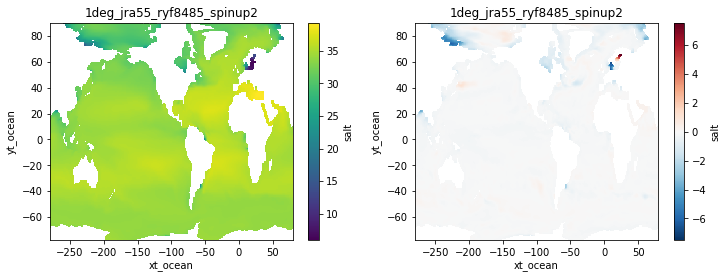

In [21]:
cc.plots.sea_surface_salinity(esub[:2])

# Zonal Mean transects

In [ ]:
cc.plots.zonal_mean(esub,'temp',n=3)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


ValueError: zero-size array to reduction operation minimum which has no identity

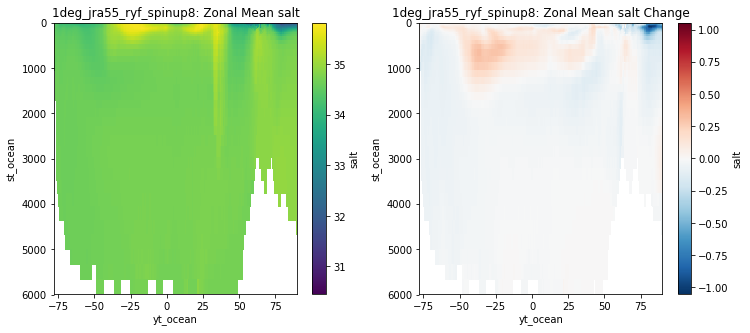

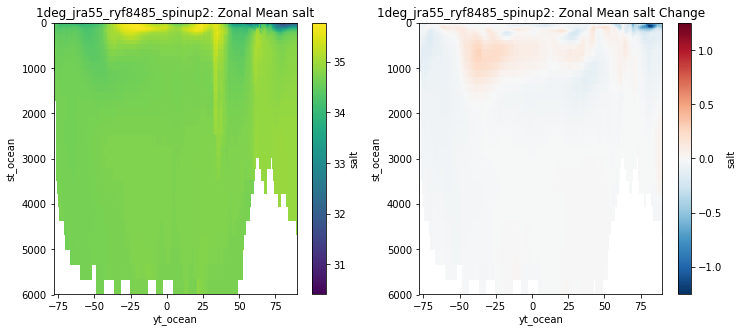

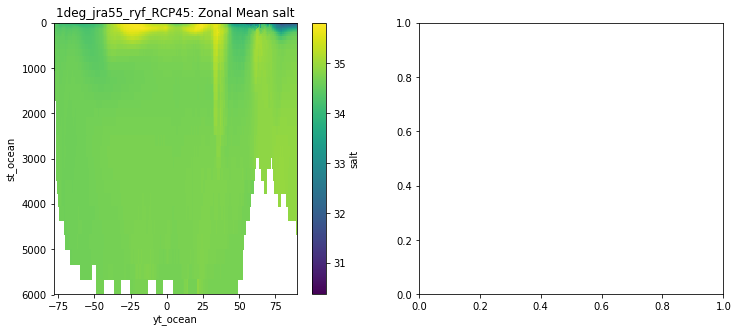

In [23]:
cc.plots.zonal_mean(esub,'salt',n=3)